In [1]:
# !pip install kneed

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2

from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

In [3]:
kaggle = pd.read_csv('.\Kaggle Datasets\data.csv')

print(kaggle.shape)
kaggle.head()

(169909, 19)


,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_date,year
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],0,0,0.708,0.1950,10,-12.428,1,0.0506,0.995,0.563,0.1510,0.7790,118.469,158648,1928,1928
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",0,0,0.379,0.0135,8,-28.454,1,0.0462,0.994,0.901,0.0763,0.0767,83.972,282133,1928,1928
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0,0,0.749,0.2200,5,-19.924,0,0.9290,0.604,0.000,0.1190,0.8800,107.177,104300,1928,1928
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],0,0,0.781,0.1300,1,-14.734,0,0.0926,0.995,0.887,0.1110,0.7200,108.003,180760,9/25/1928,1928
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",1,0,0.210,0.2040,11,-16.829,1,0.0424,0.990,0.908,0.0980,0.0693,62.149,687733,1928,1928


In [4]:
kaggle.columns

Index(['song_id', 'song_name', 'artists', 'popularity', 'explicit',
       'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'release_date', 'year'],
      dtype='object')

In [5]:
features = ['acousticness','danceability','energy','instrumentalness','liveness', 'loudness','speechiness', 'tempo','valence']

kaggle[features]

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.9950,0.708,0.1950,0.563000,0.1510,-12.428,0.0506,118.469,0.7790
1,0.9940,0.379,0.0135,0.901000,0.0763,-28.454,0.0462,83.972,0.0767
2,0.6040,0.749,0.2200,0.000000,0.1190,-19.924,0.9290,107.177,0.8800
3,0.9950,0.781,0.1300,0.887000,0.1110,-14.734,0.0926,108.003,0.7200
4,0.9900,0.210,0.2040,0.908000,0.0980,-16.829,0.0424,62.149,0.0693
...,...,...,...,...,...,...,...,...,...
169904,0.1730,0.875,0.4430,0.000032,0.0891,-7.461,0.1430,100.012,0.3060
169905,0.0167,0.719,0.3850,0.031300,0.1110,-10.907,0.0403,128.000,0.2700
169906,0.5380,0.514,0.5390,0.002330,0.1080,-9.332,0.1050,123.700,0.1530
169907,0.0714,0.646,0.7610,0.000000,0.2220,-2.557,0.0385,129.916,0.4720


In [6]:
# because the similarity, I'll be focusing just in year.
kaggle[['release_date','year']]

,release_date,year
0,1928,1928
1,1928,1928
2,1928,1928
3,9/25/1928,1928
4,1928,1928
...,...,...
169904,5/15/2020,2020
169905,6/8/2020,2020
169906,5/29/2020,2020
169907,2/28/2020,2020


In [7]:
# Focusing in the relevant metrics (by now)
X = kaggle[['artists', 'popularity', 'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year']]
# X = kaggle[['artists', 'popularity', 'explicit','danceability', 'energy', 'song_key', 'loudness', 'song_mode','speechiness',
#             'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms','year']]
X = X.set_index(kaggle['song_id'])
X

,artists,popularity,danceability,energy,song_key,loudness,song_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year
song_id,,,,,,,,,,,,,,,
6KbQ3uYMLKb5jDxLF7wYDD,['Carl Woitschach'],0,0.708,0.1950,10,-12.428,1,0.0506,0.9950,0.563000,0.1510,0.7790,118.469,158648,1928
6KuQTIu1KoTTkLXKrwlLPV,"['Robert Schumann', 'Vladimir Horowitz']",0,0.379,0.0135,8,-28.454,1,0.0462,0.9940,0.901000,0.0763,0.0767,83.972,282133,1928
6L63VW0PibdM1HDSBoqnoM,['Seweryn Goszczyński'],0,0.749,0.2200,5,-19.924,0,0.9290,0.6040,0.000000,0.1190,0.8800,107.177,104300,1928
6M94FkXd15sOAOQYRnWPN8,['Francisco Canaro'],0,0.781,0.1300,1,-14.734,0,0.0926,0.9950,0.887000,0.1110,0.7200,108.003,180760,1928
6N6tiFZ9vLTSOIxkj8qKrd,"['Frédéric Chopin', 'Vladimir Horowitz']",1,0.210,0.2040,11,-16.829,1,0.0424,0.9900,0.908000,0.0980,0.0693,62.149,687733,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4KppkflX7I3vJQk7urOJaS,"['DripReport', 'Tyga']",75,0.875,0.4430,1,-7.461,1,0.1430,0.1730,0.000032,0.0891,0.3060,100.012,163800,2020
1ehhGlTvjtHo2e4xJFB0SZ,"['Leon Bridges', 'Terrace Martin']",64,0.719,0.3850,8,-10.907,1,0.0403,0.0167,0.031300,0.1110,0.2700,128.000,167468,2020
52eycxprLhK3lPcRLbQiVk,"['Kygo', 'Oh Wonder']",70,0.514,0.5390,7,-9.332,1,0.1050,0.5380,0.002330,0.1080,0.1530,123.700,180700,2020


In [8]:
# I have to code the artists to numbers.

le = LabelEncoder()
trans_artists = le.fit_transform(X['artists'])
trans_artists

array([ 4880, 25163, 26351, ..., 16987,  5031, 13224])

In [9]:
X['artists'] = trans_artists
X.head()

,artists,popularity,danceability,energy,song_key,loudness,song_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year
song_id,,,,,,,,,,,,,,,
6KbQ3uYMLKb5jDxLF7wYDD,4880,0,0.708,0.1950,10,-12.428,1,0.0506,0.995,0.563,0.1510,0.7790,118.469,158648,1928
6KuQTIu1KoTTkLXKrwlLPV,25163,0,0.379,0.0135,8,-28.454,1,0.0462,0.994,0.901,0.0763,0.0767,83.972,282133,1928
6L63VW0PibdM1HDSBoqnoM,26351,0,0.749,0.2200,5,-19.924,0,0.9290,0.604,0.000,0.1190,0.8800,107.177,104300,1928
6M94FkXd15sOAOQYRnWPN8,9738,0,0.781,0.1300,1,-14.734,0,0.0926,0.995,0.887,0.1110,0.7200,108.003,180760,1928
6N6tiFZ9vLTSOIxkj8qKrd,10245,1,0.210,0.2040,11,-16.829,1,0.0424,0.990,0.908,0.0980,0.0693,62.149,687733,1928


In [10]:
# Now I have to normalize the vectors 

stdscaler = StandardScaler()
X_std = stdscaler.fit_transform(X)
X_std

array([[-1.2417585 , -1.46213535,  0.96866192, ...,  0.04950012,
        -0.59971332, -1.92330144],
       [ 0.85327413, -1.46213535, -0.90763624, ..., -1.07319889,
         0.41811891, -1.92330144],
       [ 0.97598274, -1.46213535,  1.20248631, ..., -0.3179961 ,
        -1.04767984, -1.92330144],
       ...,
       [ 0.00877446,  1.78122556, -0.13772666, ...,  0.21974213,
        -0.41794844,  1.67141853],
       [-1.2261617 ,  1.78122556,  0.61507382, ...,  0.4220408 ,
        -0.52833277,  1.67141853],
       [-0.3799061 ,  1.54955693, -0.14913272, ..., -1.1833306 ,
        -0.13698438,  1.67141853]])

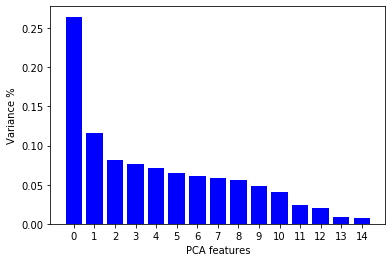

In [11]:
# I'm running PCA first

pca = PCA(n_components=X_std.shape[1])

principal_components = pca.fit_transform(X_std)

# Plot the explained variances

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.xticks(features)

# save components to a dataframe

PCA_components = pd.DataFrame(principal_components)


Text(0, 0.5, 'PCA 2')

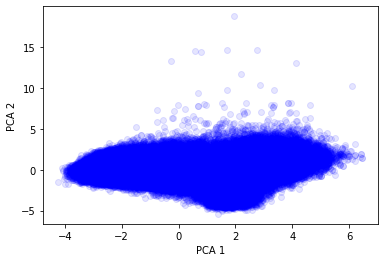

In [12]:
plt.scatter(PCA_components[0],PCA_components[1], alpha=.1, color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

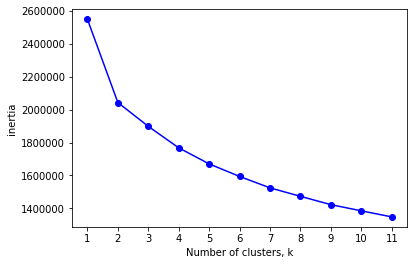

In [13]:
# Find the clusters

ks = range(1,12)
inertias = list()

for k in ks:
    # Create a KMeans instance with k clusters
    model = KMeans(n_clusters = k, random_state=42)
    
    # Fit model to samples
    model.fit(X_std)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot the inertias

plt.plot(ks,inertias, '-o', color='blue')
plt.xlabel('Number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [14]:
kl = KneeLocator(range(1,12),inertias, curve='convex',direction='decreasing')
kl.elbow

4

In [15]:
# Defining a function that performs the PCA and clustering, due I'm repeting a couple of times.

def pca_n_clustering(dataset,columns, index_column,encoding_column,max_n_clusters):
    
    # Setting the subset I'm working with
    X = dataset[columns]
    X = X.set_index(dataset[index_column])
    
    # Enconding categorical data
    # in this case, the artists names
    le = LabelEncoder()
    trans_artists = le.fit_transform(X[encoding_column])
    X[encoding_column] = trans_artists
    
    # Standarizing the data
    stdscaler = StandardScaler()
    X_std = stdscaler.fit_transform(X)
    
    # PCA
    pca = PCA(n_components=X_std.shape[1])

    principal_components = pca.fit_transform(X_std)

    # Plot the explained variances

    features = range(pca.n_components_)
       
    plt.bar(features, pca.explained_variance_ratio_, color='blue')
    plt.xlabel('PCA features')
    plt.ylabel('Variance %')
    plt.xticks(features)

    # Save components to a dataframe

    PCA_components = pd.DataFrame(principal_components)
    
    # Plot
#     plt.scatter(PCA_components[0],PCA_components[1], alpha=.1, color='blue')
#     plt.xlabel('PCA 1')
#     plt.ylabel('PCA 2')
    
    # Elbow test
    
    ks = range(1,max_n_clusters)
    inertias = list()

    for k in ks:
        # Create a KMeans instance with k clusters
        model = KMeans(n_clusters = k, random_state=42)

        # Fit model to samples
        model.fit(X_std)

        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)

#     Plot the inertias

    plt.plot(ks,inertias, '-o', color='blue')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()
    
    kl = KneeLocator(range(1,max_n_clusters),inertias, curve='convex',direction='decreasing')
    print('Suggested number of clusters:',kl.elbow)
    return X_std

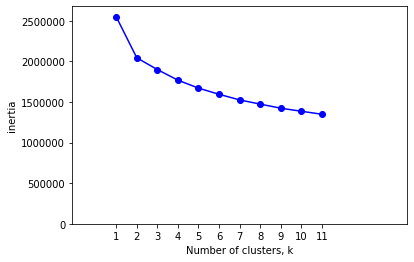

Suggested number of clusters: 4


array([[-1.2417585 , -1.46213535,  0.96866192, ...,  0.04950012,
        -0.59971332, -1.92330144],
       [ 0.85327413, -1.46213535, -0.90763624, ..., -1.07319889,
         0.41811891, -1.92330144],
       [ 0.97598274, -1.46213535,  1.20248631, ..., -0.3179961 ,
        -1.04767984, -1.92330144],
       ...,
       [ 0.00877446,  1.78122556, -0.13772666, ...,  0.21974213,
        -0.41794844,  1.67141853],
       [-1.2261617 ,  1.78122556,  0.61507382, ...,  0.4220408 ,
        -0.52833277,  1.67141853],
       [-0.3799061 ,  1.54955693, -0.14913272, ..., -1.1833306 ,
        -0.13698438,  1.67141853]])

In [16]:
pca_n_clustering(kaggle,['artists', 'popularity', 'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year'], 'song_id', 'artists',12)

In [17]:
# I'm going with 4 clusters in a initial stage


# Create a KMeans instance with k clusters
model = KMeans(n_clusters = 4, random_state=42)

# Fit model to samples
model.fit_predict(X_std)

centers = model.cluster_centers_

labels = model.labels_

labels

array([2, 1, 0, ..., 3, 3, 3])

In [18]:
temp_df = kaggle.copy()
temp_df['cluster'] = labels
display(temp_df.head())
temp_df.shape

,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_date,year,cluster
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],0,0,0.708,0.1950,10,-12.428,1,0.0506,0.995,0.563,0.1510,0.7790,118.469,158648,1928,1928,2
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",0,0,0.379,0.0135,8,-28.454,1,0.0462,0.994,0.901,0.0763,0.0767,83.972,282133,1928,1928,1
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0,0,0.749,0.2200,5,-19.924,0,0.9290,0.604,0.000,0.1190,0.8800,107.177,104300,1928,1928,0
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],0,0,0.781,0.1300,1,-14.734,0,0.0926,0.995,0.887,0.1110,0.7200,108.003,180760,9/25/1928,1928,2
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",1,0,0.210,0.2040,11,-16.829,1,0.0424,0.990,0.908,0.0980,0.0693,62.149,687733,1928,1928,1


(169909, 20)

In [19]:
kaggle_groups = temp_df.groupby(['cluster'])

cluster_0 =  kaggle_groups.get_group((0))
cluster_1 = kaggle_groups.get_group((1))
cluster_2 = kaggle_groups.get_group((2))
cluster_3 = kaggle_groups.get_group((3))

print(cluster_0.shape)
print(cluster_1.shape)
print(cluster_2.shape)
print(cluster_3.shape)


(4499, 20)
(32041, 20)
(47166, 20)
(86203, 20)


In [20]:
# building a dictionary to store the dataframes

clustering_dict = {}


In [21]:
# Define a function that splits the dataframe, according to the subclusters

def split_dfs(df,k,labels_list,centroids_list,dict_to_use):
    
    temp_df = df.copy()
    temp_df['cluster'] = labels_list

    kaggle_groups = temp_df.groupby(['cluster'])
        
    dict_to_use['centroids'] = centroids_list
        
    for i in range(k):

        if i not in dict_to_use:

            dict_to_use[i] = {'main':None,'subclusters': dict()}
        dict_to_use[i]['main'] = kaggle_groups.get_group((i))



In [22]:
split_dfs(kaggle,4,labels,centers,clustering_dict)
clustering_dict[0]['main']

,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_date,year,cluster
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0,0,0.749,0.220,5,-19.924,0,0.929,0.6040,0.0,0.119,0.880,107.177,104300,1928,1928,0
9,6PrZexNb16cabXR8Q418Xc,Chapter 1.3 - Zamek kaniowski,['Seweryn Goszczyński'],0,0,0.674,0.205,9,-20.119,1,0.954,0.8460,0.0,0.170,0.759,81.249,111600,1928,1928,0
29,6XD6qJykJ91uC9AYb84ZeY,Chapter 4.12 - Zamek kaniowski,['Seweryn Goszczyński'],0,0,0.715,0.220,2,-19.788,1,0.948,0.6860,0.0,0.206,0.545,113.214,102200,1928,1928,0
38,6aXTusFB0Ycjmt9TXr2cfK,Chapter 4.10 - Zamek kaniowski,['Seweryn Goszczyński'],0,0,0.677,0.204,1,-20.024,0,0.957,0.7080,0.0,0.104,0.667,84.826,95900,1928,1928,0
39,6bKJYhoaWIohnhspidbdW7,Chapter 2.11 - Zamek kaniowski,['Seweryn Goszczyński'],0,0,0.738,0.282,1,-16.556,1,0.952,0.7770,0.0,0.290,0.703,140.612,139100,1928,1928,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167062,3LIRN0Gxdr7cqxkRLUigjT,"Sit Down, You're Rockin' the Boat","['Walter Bobbie', 'Guys and Dolls Ensemble (19...",38,0,0.577,0.299,10,-15.740,1,0.459,0.8420,0.0,0.769,0.517,129.040,177133,7/7/1992,1992,0
167734,4PX9Ga99IMqlbgKucTxupc,The Car Bomb,"['Dr. Dre', 'Mel-Man', 'Charis Henry']",47,1,0.538,0.850,5,-9.413,0,0.854,0.6750,0.0,0.360,0.459,87.816,60893,11/16/1999,1999,0
167770,59z8uxWZVFpL2LfZ5C9AzY,Public Service Announcement,['Eminem'],47,1,0.660,0.199,9,-25.602,1,0.871,0.2960,0.0,0.145,0.921,147.535,33093,2/23/1999,1999,0
168252,5MAY7XyW322jMwLDtBQgsZ,School Spirit Skit 2,['Kanye West'],46,1,0.716,0.308,5,-12.629,1,0.925,0.3340,0.0,0.215,0.830,128.412,43533,2/10/2004,2004,0


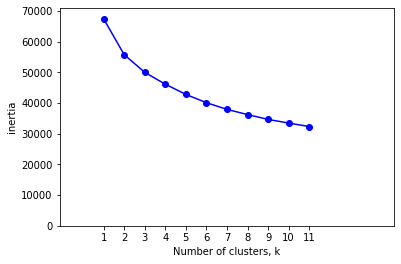

Suggested number of clusters: 4


In [23]:
# For cluster 0:

X_std_0 = pca_n_clustering(cluster_0,['artists', 'popularity', 'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year'], 'song_id', 'artists',12)

In [24]:
#Create a KMeans instance with k clusters
model = KMeans(n_clusters = 4, random_state=42)

# Fit model to samples
model.fit_predict(X_std_0)

centers_0 = model.cluster_centers_

labels_0 = model.labels_

split_dfs(clustering_dict[0]['main'],4,labels_0,centers_0,clustering_dict[0]['subclusters'])
print(clustering_dict[0]['subclusters'][0]['main'].shape)
print(clustering_dict[0]['subclusters'][1]['main'].shape)
print(clustering_dict[0]['subclusters'][2]['main'].shape)
print(clustering_dict[0]['subclusters'][3]['main'].shape)


(78, 20)
(2485, 20)
(517, 20)
(1419, 20)


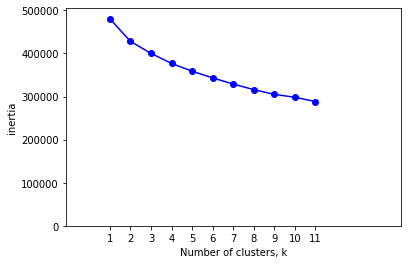

Suggested number of clusters: 4


In [25]:
# For cluster 1:

X_std_1 = pca_n_clustering(cluster_1,['artists', 'popularity', 'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year'], 'song_id', 'artists',12)

In [26]:
#Create a KMeans instance with k clusters
model = KMeans(n_clusters = 4, random_state=42)

# Fit model to samples
model.fit_predict(X_std_1)

centers_1 = model.cluster_centers_

labels_1 = model.labels_

split_dfs(clustering_dict[1]['main'],4,labels_1,centers_1,clustering_dict[1]['subclusters'])
print(clustering_dict[1]['subclusters'][0]['main'].shape)
print(clustering_dict[1]['subclusters'][1]['main'].shape)
print(clustering_dict[1]['subclusters'][2]['main'].shape)
print(clustering_dict[1]['subclusters'][3]['main'].shape)

(13210, 20)
(7307, 20)
(4094, 20)
(7430, 20)


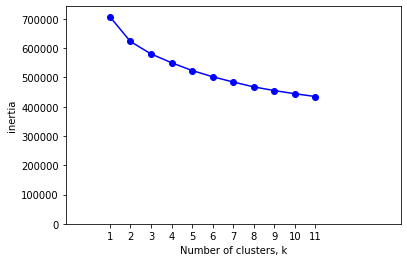

Suggested number of clusters: 4


In [27]:
# For cluster 2:

X_std_2 = pca_n_clustering(cluster_2,['artists', 'popularity', 'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year'], 'song_id', 'artists',12)

In [28]:
#Create a KMeans instance with k clusters
model = KMeans(n_clusters = 4, random_state=42)

# Fit model to samples
model.fit_predict(X_std_2)

centers_2 = model.cluster_centers_

labels_2 = model.labels_

split_dfs(clustering_dict[2]['main'],4,labels_2,centers_2,clustering_dict[2]['subclusters'])
print(clustering_dict[2]['subclusters'][0]['main'].shape)
print(clustering_dict[2]['subclusters'][1]['main'].shape)
print(clustering_dict[2]['subclusters'][2]['main'].shape)
print(clustering_dict[2]['subclusters'][3]['main'].shape)

(11947, 20)
(14788, 20)
(14253, 20)
(6178, 20)


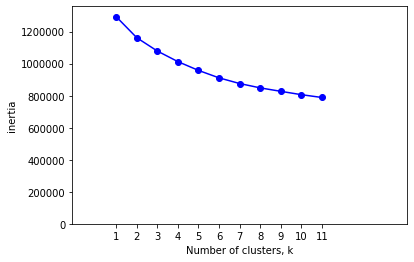

Suggested number of clusters: 5


In [29]:
# For cluster 3:
X_std_3 = pca_n_clustering(cluster_3,['artists', 'popularity', 'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year'], 'song_id', 'artists',12)

In [30]:
#Create a KMeans instance with k clusters
model = KMeans(n_clusters = 5, random_state=42)

# Fit model to samples
model.fit_predict(X_std_3)

centers_3 = model.cluster_centers_

labels_3 = model.labels_

split_dfs(clustering_dict[3]['main'],5,labels_3,centers_3,clustering_dict[3]['subclusters'])
print(clustering_dict[3]['subclusters'][0]['main'].shape)
print(clustering_dict[3]['subclusters'][1]['main'].shape)
print(clustering_dict[3]['subclusters'][2]['main'].shape)
print(clustering_dict[3]['subclusters'][3]['main'].shape)
print(clustering_dict[3]['subclusters'][4]['main'].shape)

(16185, 20)
(27383, 20)
(5636, 20)
(28117, 20)
(8882, 20)


In [31]:
# Now I have to measure similarities within subclusters.

demo = clustering_dict[0]['subclusters'][0]['main'][['popularity','danceability', 'energy', 'song_key', 'loudness', 'song_mode','speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year']]
demo.head()

# Standarizing the data
stdscaler = StandardScaler()
demo_std = stdscaler.fit_transform(demo)

demo_std = demo_std / np.linalg.norm(demo_std,axis=1, keepdims=True)
demo_std

array([[-0.14104352,  0.35775496,  0.01410048, ..., -0.21337356,
        -0.01301241, -0.14738939],
       [-0.11814379,  0.22600687, -0.41813347, ..., -0.37315   ,
         0.0045487 , -0.12345935],
       [-0.13190641,  0.06214454, -0.30514646, ...,  0.66242168,
        -0.00671692,  0.04394936],
       ...,
       [-0.11345452,  0.1131378 , -0.14475097, ...,  0.57616089,
        -0.04987217, -0.14089633],
       [-0.12835809,  0.51815531, -0.15073796, ...,  0.08471963,
        -0.04733507, -0.00777584],
       [-0.13280254,  0.30062549, -0.07807976, ...,  0.05912355,
        -0.00860264,  0.01810143]])

In [32]:
demo_std.dot(np.transpose(demo_std))

array([[ 1.        ,  0.82070369, -0.07288224, ...,  0.03032858,
         0.2031113 ,  0.79817894],
       [ 0.82070369,  1.        , -0.02750255, ...,  0.09932839,
         0.25713565,  0.66922535],
       [-0.07288224, -0.02750255,  1.        , ...,  0.58587975,
         0.62733607,  0.23768352],
       ...,
       [ 0.03032858,  0.09932839,  0.58587975, ...,  1.        ,
         0.51964783,  0.45288467],
       [ 0.2031113 ,  0.25713565,  0.62733607, ...,  0.51964783,
         1.        ,  0.50393   ],
       [ 0.79817894,  0.66922535,  0.23768352, ...,  0.45288467,
         0.50393   ,  1.        ]])

In [106]:
def build_sim_dict(clust_num,subclust_num,row):
    
    '''
    Find the similarity measure based on the angle between the vectors, 
    and build a dictionary with the cosine of the angle as key.
    List of songs with the same rounded cosine.
    '''
    
    partial_df = clustering_dict[clust_num]['subclusters'][subclust_num]['main'][['popularity','danceability', 'energy', 'song_key', 'loudness', 'song_mode','speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year']]
    partial_df.head()

    # Standarizing the data
    stdscaler = StandardScaler()
    partial_df_std = stdscaler.fit_transform(partial_df)

    partial_df_std = partial_df_std / np.linalg.norm(partial_df_std,axis=1, keepdims=True)  
    
    similarity_dict = {}
    for i, _ in enumerate(partial_df.index):

        similarity = round(partial_df_std.dot(np.transpose(partial_df_std))[row][i],4)


        if similarity not in similarity_dict:

            similarity_dict[similarity] = []
            
        similarity_dict[similarity].append(clustering_dict[clust_num]['subclusters'][subclust_num]['main'].iloc[i,0])

    return similarity_dict

# build_sim_dict(0,0,0)

In [91]:
# lst_of_sim_dcts = [build_sim_dict(0,0,row) for row in range(len(clustering_dict[0]['subclusters'][0]['main']))]

In [ ]:
# Build a dict with song_id as key
song_dict = {}

for i in range(len(clustering_dict.keys())-2):

    for j in range(len(clustering_dict[i]['subclusters'].keys())-2):

        lst_of_sim_dcts = [build_sim_dict(i,j,row) for row in range(len(clustering_dict[i]['subclusters'][j]['main']))]

        for k,id in enumerate(clustering_dict[i]['subclusters'][j]['main']['song_id']):

            song_dict[id] = lst_of_sim_dcts[k]
            
        del lst_of_sim_dcts



In [109]:
song_dict

{'5DUSpk3Gy56S0dbwZidI4W': {1.0: ['5DUSpk3Gy56S0dbwZidI4W'],
  0.8207: ['5DpzoCNr6dtH6pjL4NDtO2'],
  -0.0729: ['1oJEYsx2uClmUgl3tS01OS'],
  -0.1865: ['0rfSbPXwogMdzQL4HhHJeE'],
  -0.208: ['0sAUubq7je0VmdJxctYFeZ'],
  0.0461: ['31o9lLrNYqGF69n6vwKcky'],
  0.6968: ['33HokgEqd1RcaYRvarbjsB'],
  -0.2573: ['1ayelKXpu6jygeSUTp6J37'],
  0.3906: ['00MqCzhctS3pKiTS1w4auO'],
  -0.1458: ['125jkO66tt3hHwEKhlX62B'],
  -0.2628: ['5p2B5ErgcXPKk8UJmmf8y8'],
  0.6853: ['661tQ1QrcWfK1JFWgMiCgK'],
  0.2136: ['6O95F2fruMSR0KTUnAbUL7'],
  -0.3781: ['0DTRhASyyVjXiFwyT96YHK'],
  -0.032: ['0EQNtcGdZj5m3lctgY31Uy', '7H5IhO6BNYjyEykl9uZ1Fq'],
  -0.3091: ['2ALjYTnVOy0LINGcpm0LqA'],
  -0.352: ['3qlhpwcyz1bt2Xm3R1rFLc'],
  0.1606: ['6UYw027SUEmi66sPba5kZA'],
  -0.2042: ['6mGIAipyDtlBdMxpxUyUq3'],
  0.011: ['2oaLzpMc0MWw0JjIJZ3wtL'],
  0.0691: ['1OOOjuRfvzeTIC0t0KJ4ln'],
  0.2534: ['1OXTNSlAEV8DaEibFduAv9'],
  0.608: ['1XVxILstgXGQAkRPUjBkRp'],
  0.3522: ['3Q8nH5c6iiDr9f7myrgWhB'],
  -0.1839: ['6NqUceA124QO9v5jYv0Q

# Area 51

In [38]:
clustering_dict[0]['subclusters'][0]['main']

,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_date,year,cluster
533,5DUSpk3Gy56S0dbwZidI4W,Aa Gaya Mere Bagh Ka Mali,['Noor Jehan'],0,0,0.737,0.3490,9,-12.893,1,0.691,0.991,0.914,0.1560,0.824,87.775,180140,12/1/1942,1942,0
534,5DpzoCNr6dtH6pjL4NDtO2,Sajan Aaye Gali Men Ram Kasam,['Vimla'],0,0,0.705,0.0263,9,-14.740,1,0.768,0.995,0.816,0.0951,0.945,65.614,188624,12/31/1942,1942,0
1002,1oJEYsx2uClmUgl3tS01OS,Rog Na Parakhan Kar Jo,"['A. R. Oza', 'Geeta Dutt']",0,0,0.631,0.1350,5,-11.052,0,0.718,0.995,0.625,0.1540,0.727,175.776,182822,6/3/1949,1949,0
1074,0rfSbPXwogMdzQL4HhHJeE,"N'Goundi Girls' Song (Female Chorus, Handclapp...","[""Female N'Goundi soloist, girls' chorus""]",0,0,0.596,0.3480,10,-20.640,1,0.645,0.982,0.425,0.0965,0.241,136.475,75707,1/1/1950,1950,0
1079,0sAUubq7je0VmdJxctYFeZ,"Okandi Women's Song (Female Chorus, Drums)","['Female Okandi chorus, three male drummers']",0,0,0.563,0.5400,10,-19.194,0,0.866,0.973,0.527,0.0910,0.523,165.881,100653,1/1/1950,1950,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161840,4PBRpJMVtR63FmrBvrSKBX,Frankie And Albert (127-B),['Lead Belly'],0,0,0.638,0.8410,1,-10.513,1,0.769,0.961,0.493,0.1140,0.295,106.012,248033,1935,1935,0
162060,01Y18gBkuG9FgzkCJjivAP,"Concierto de Aranjuez, III Allegro gentile","['Joaquín Rodrigo', 'Ars Cantus - Voci Bianche...",0,0,0.367,0.5410,2,-19.003,1,0.626,0.901,0.909,0.8370,0.501,155.668,366116,1939,1939,0
162209,7sI39pAtruascTzk637nBF,Diwali Phir Aa Gai Sajni,['Shamshad Begum'],0,0,0.658,0.2270,6,-11.921,1,0.680,0.992,0.327,0.1770,0.873,176.536,157605,12/1/1941,1941,0
162617,4VU5AaCNGR8Wi4HlYhCpVR,Barhe Chalo Barhe Chalo,['Nadira'],0,0,0.814,0.2360,7,-10.118,0,0.659,0.995,0.455,0.1160,0.804,117.036,162199,1/1/1947,1947,0
